# Loading the data + importing basic packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
## Only needed if running it on Google Colab ##

# import nltk
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('omw-1.4')
# nltk.download('stopwords')

# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.getcwd()
# os.chdir('/content/drive/MyDrive/raw_data')

In [4]:
data = pd.read_csv('../raw_data/data_3k.csv')
data.head()

,Unnamed: 0,id,title,text,topic,subtopic
0,0,https://openalex.org/W2100716186,Large-scale screening of hypothetical metal-or...,PUBLISHED ONLINE: 6 NOVEMBER 2011 | DOI: 10.10...,Chemistry,Nanotechnology
1,1,https://openalex.org/W2109370530,Routing and wavelength assignment in all-optic...,"[H+./ACM TRANSACTIONS ON NETWORKING, VO1. 3, N...",Computer science,Telecommunications
2,2,https://openalex.org/W2131625303,Potassium channel antibody-associated encephal...,"DOI: 10.1093/brain/awh077 Brain (2004), 127, ...",Medicine,Pediatrics
3,3,https://openalex.org/W2131736388,"MODBASE, a database of annotated comparative p...","D336–D346 Nucleic Acids Research, 2014, Vol. 4...",Computer science,Bioinformatics
4,4,https://openalex.org/W2144966005,Regional brain volume abnormalities and long-t...,ORIGINAL CONTRIBUTION Regional Brain Volume A...,Medicine,Internal medicine


## 1. Preprocessing

In [5]:
data = data.drop(columns='Unnamed: 0')

In [6]:
import string
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))

def preprocessing(pdf):
    # Turn all text to lowercase
    pdf = str(pdf).lower()
    
    # Removing anything apart from lower case letters
    pdf = re.sub(r'[^a-z]', ' ', str(pdf))
    
    # Removing everything before the abstract
    pdf = re.sub(r"^.+?(?=abstract)", "", str(pdf))
    pdf = pdf.lstrip('abstract')
    pdf = pdf.lstrip()
    
    # Removing single letter words
    pdf = ' '.join(w for w in pdf.split() if len(w)>1)
    
    # Removing whitespace
    pdf = pdf.strip()

    # To save computational costs, we will implement a longest_token_size here
    longest_token_size = 1000 
    num_of_words_to_keep = int(longest_token_size*5) # adding some margin, because in spotword removal and word2vec embedding some will be removed
    pdf = ' '.join(pdf.split()[:num_of_words_to_keep])
    
    # Turn words into numerical tokens and remove stopwords
    word_tokens = word_tokenize(pdf)
    pdf = [w for w in word_tokens if not w in stop_words]
    
    # Lemmatizing words(Turning each verb and noun into its core)
    pdf = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in pdf]
    pdf = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in pdf]
    return ' '.join(pdf)

In [7]:
data['clean_text'] = data['text'].map(lambda x: preprocessing(x))
data

,id,title,text,topic,subtopic,clean_text
0,https://openalex.org/W2100716186,Large-scale screening of hypothetical metal-or...,PUBLISHED ONLINE: 6 NOVEMBER 2011 | DOI: 10.10...,Chemistry,Nanotechnology,publish online november doi nchem article larg...
1,https://openalex.org/W2109370530,Routing and wavelength assignment in all-optic...,"[H+./ACM TRANSACTIONS ON NETWORKING, VO1. 3, N...",Computer science,Telecommunications,acm transaction network vo october rout wavele...
2,https://openalex.org/W2131625303,Potassium channel antibody-associated encephal...,"DOI: 10.1093/brain/awh077 Brain (2004), 127, ...",Medicine,Pediatrics,doi brain awh brain potassium channel antibody...
3,https://openalex.org/W2131736388,"MODBASE, a database of annotated comparative p...","D336–D346 Nucleic Acids Research, 2014, Vol. 4...",Computer science,Bioinformatics,modbase http salilab org modbase database anno...
4,https://openalex.org/W2144966005,Regional brain volume abnormalities and long-t...,ORIGINAL CONTRIBUTION Regional Brain Volume A...,Medicine,Internal medicine,original contribution regional brain volume ab...
...,...,...,...,...,...,...
2915,https://openalex.org/W2122538288,Tissue-specific expression and regulation of s...,"The Plant Cell, Vol. 5, 9-23, January 1993...",Biology,Genetics,plant cell vol january american society plant ...
2916,https://openalex.org/W2133765154,Interleukin-23 drives innate and T cell–mediat...,Downloaded from genesdev.cshlp.org on Sept...,Medicine,Immunology,download genesdev cshlp org september publish ...
2917,https://openalex.org/W2142740946,Isolation with Migration Models for More Than ...,Energy & Environmental Science PAPER Entropi...,Biology,Evolutionary biology,energy environmental science paper entropic st...
2918,https://openalex.org/W2152560313,The Impact of Electronic Health Records on Tim...,"Coffelt, S. B., Wellenstein, M. D., and de Vis...",Medicine,Medical emergency,offelt wellenstein de visser neutrophil cancer...


**Filtering the topics and the subtopics**

In [54]:
# Filtering for those topics that occurr more commonly in our data        <----- percentile can be adjusted
common_topics = (data['topic'].value_counts() > np.percentile(data['topic'].value_counts(), 25)) # topic occurrence until 25th percentile
filtered_topics = common_topics[common_topics == True].index

# Filtering for those subtopics that occurr more commonly in our data     <----- instead of cutting of at the mean, can also be adjusted like above
# common_subtopics = (data['subtopic'].value_counts() > data['subtopic'].value_counts().mean())
# filtered_subtopics = common_subtopics[common_subtopics == True].index

# Filtering data according to the topics and subtopics that are more common
top4 = ['Biology', 'Medicine', 'Physics', 'Mathematics']
data = data[data['topic'].isin(list(top4))]
# data = data[data['topic'].isin(list(filtered_topics))]

In [55]:
data['topic'].value_counts()

Biology        940
Medicine       701
Physics        113
Mathematics     78
Name: topic, dtype: int64

In [10]:
num_of_topics = common_topics.value_counts()[1]
num_of_topics

14

## 2. Creating the models

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, Sequential

In [56]:
topic_df = data.copy()

**Checking the subtopics for each topic**

In [13]:
from collections import Counter

print(Counter(data[data['topic'] == 'Physics']['subtopic']))

Counter({'Astronomy': 32, 'Quantum mechanics': 8, 'Classical mechanics': 7, 'Astrophysics': 6, 'Theoretical physics': 5, 'Neuroscience': 4, 'Computational physics': 4, 'Mechanics': 4, 'Condensed matter physics': 4, 'Statistical physics': 3, 'Nuclear physics': 3, 'Optics': 3, 'Geometry': 2, 'Systems engineering': 2, 'Atomic physics': 2, 'Mathematical physics': 2, 'Astrobiology': 2, 'Quantum electrodynamics': 2, 'Particle physics': 2, 'Biological system': 2, 'Chemical physics': 1, 'Electrical engineering': 1, 'Simulation': 1, 'Applied mathematics': 1, 'Electronic engineering': 1, 'Nuclear medicine': 1, 'Optoelectronics': 1, 'Nanotechnology': 1, 'Molecular physics': 1, 'Physical medicine and rehabilitation': 1, 'Geochemistry': 1, 'Pure mathematics': 1, 'Meteorology': 1, 'Thermodynamics': 1})


### 2.1 Creating the main model for the topics

**Encoding the target, splitting the data into train/test and padding**

In [57]:
enc = OneHotEncoder(sparse = False, handle_unknown='ignore')
y_topic = enc.fit_transform(topic_df[['topic']])
new_column_names = enc.get_feature_names_out()
y_topic = pd.DataFrame(y_topic)
y_topic.columns = new_column_names

In [58]:
X = topic_df['clean_text']

X_topic_train, X_topic_test, y_topic_train, y_topic_test = train_test_split(
    X, y_topic, test_size=0.3, random_state=1)

**Rebalancing the dataset by giving each category weighting based on its occurrence**

In [59]:
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(np.array(y_topic_train), axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
y_topic_class_weights = dict(enumerate(class_weights))
y_topic_class_weights

{0: 0.48634294385432475,
 1: 5.62280701754386,
 2: 0.6540816326530612,
 3: 4.217105263157895}

In [60]:
tk = Tokenizer()
tk.fit_on_texts(X_topic_train)
sequences = tk.texts_to_sequences(X_topic_train)

In [61]:
topic_vocab_size = len(tk.word_index)
X_pad_topic = pad_sequences(sequences, dtype='float32', padding='post', maxlen=1500)
print(X_pad_topic.shape, topic_vocab_size)

(1282, 1500) 85050


**Building the Recurrent neural network**

In [64]:
# Size of your embedding space = size of the vector representing each word
embedding_size = 50

topic_model = Sequential()
topic_model.add(layers.Embedding(
    input_dim=topic_vocab_size+1,
    output_dim=embedding_size,
    mask_zero=True, # Built-in masking layer :)
))

topic_model.add(layers.LSTM(20))
topic_model.add(layers.Dense(len(top4), activation="softmax"))
topic_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 50)          4252550   
                                                                 
 lstm_3 (LSTM)               (None, 20)                5680      
                                                                 
 dense_3 (Dense)             (None, 4)                 84        
                                                                 
Total params: 4,258,314
Trainable params: 4,258,314
Non-trainable params: 0
_________________________________________________________________


**Compiling and training the model**

In [20]:
# Defining the F1 score manually
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
y_topic_train.shape

(2027, 14)

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5,restore_best_weights=True, monitor='val_accuracy')

topic_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy',f1_m])

history = topic_model.fit(X_pad_topic, y_topic_train, 
                          class_weight=y_topic_class_weights, 
                          epochs=20, validation_split=0.3, batch_size=32, 
                          verbose=1, callbacks=[es])

Epoch 1/20
29/29 [==============================] - 21s 586ms/step - loss: 1.4147 - accuracy: 0.2297 - f1_m: 0.0000e+00 - val_loss: 1.3760 - val_accuracy: 0.3403 - val_f1_m: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 16s 545ms/step - loss: 1.3876 - accuracy: 0.5975 - f1_m: 0.0000e+00 - val_loss: 1.3500 - val_accuracy: 0.4234 - val_f1_m: 0.0000e+00
Epoch 3/20
29/29 [==============================] - 16s 556ms/step - loss: 1.2953 - accuracy: 0.6589 - f1_m: 0.0000e+00 - val_loss: 1.2855 - val_accuracy: 0.4000 - val_f1_m: 0.0000e+00
Epoch 4/20
29/29 [==============================] - 18s 613ms/step - loss: 1.1357 - accuracy: 0.6700 - f1_m: 0.0144 - val_loss: 1.2513 - val_accuracy: 0.4130 - val_f1_m: 0.0182
Epoch 5/20
29/29 [==============================] - 17s 570ms/step - loss: 0.9742 - accuracy: 0.6366 - f1_m: 0.2069 - val_loss: 1.2851 - val_accuracy: 0.3481 - val_f1_m: 0.1299
Epoch 6/20
29/29 [==============================] - 16s 554ms/step - loss: 0.8086 - accurac

**Padding the test set and evaluating it**

In [66]:
sequences2 = tk.texts_to_sequences(X_topic_test)
X_pad_topic2 = pad_sequences(sequences2, dtype='float32', padding='post')

In [67]:
y_pred = topic_model.predict(X_pad_topic2)

18/18 [==============================] - 6s 260ms/step


18/18 [==============================] - 5s 275ms/step


<AxesSubplot:>

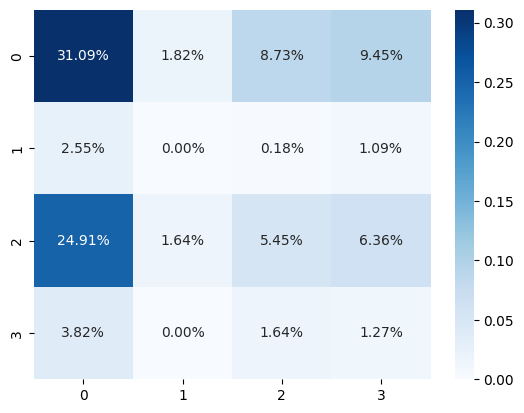

In [68]:
from tensorflow.math import confusion_matrix
# Making a confusion matrix
y_test_id = np.argmax(np.array(y_topic_test), axis=1)
y_pred_id = np.argmax(topic_model.predict(X_pad_topic2), axis=1)
conf_matrix = confusion_matrix(labels=y_test_id, predictions=y_pred_id)

import seaborn as sns
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [69]:
# test values are the X and pred values are the Y
top4

['Biology', 'Medicine', 'Physics', 'Mathematics']

In [75]:
print(Counter(data[data['topic'] == 'Physics']['subtopic']))

Counter({'Astronomy': 32, 'Quantum mechanics': 8, 'Classical mechanics': 7, 'Astrophysics': 6, 'Theoretical physics': 5, 'Neuroscience': 4, 'Computational physics': 4, 'Mechanics': 4, 'Condensed matter physics': 4, 'Statistical physics': 3, 'Nuclear physics': 3, 'Optics': 3, 'Geometry': 2, 'Systems engineering': 2, 'Atomic physics': 2, 'Mathematical physics': 2, 'Astrobiology': 2, 'Quantum electrodynamics': 2, 'Particle physics': 2, 'Biological system': 2, 'Chemical physics': 1, 'Electrical engineering': 1, 'Simulation': 1, 'Applied mathematics': 1, 'Electronic engineering': 1, 'Nuclear medicine': 1, 'Optoelectronics': 1, 'Nanotechnology': 1, 'Molecular physics': 1, 'Physical medicine and rehabilitation': 1, 'Geochemistry': 1, 'Pure mathematics': 1, 'Meteorology': 1, 'Thermodynamics': 1})


The Confusion matrix shows that the model is good at predicting biology articles (0 to 0 being 30.41%) but not very good at anything else

In [70]:
topic_model.evaluate(X_pad_topic2,y_topic_test)

18/18 [==============================] - 6s 258ms/step - loss: 1.3518 - accuracy: 0.3782 - f1_m: 0.0000e+00


[1.3517571687698364, 0.3781818151473999, 0.0]

### 2.2 Creating the second model for the subtopics 